In [1]:
import os
os.chdir('../')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as tF
import numpy as np
import matplotlib.pyplot as plt

import functional as F

In [3]:
def label_to_membership(labels):
    n_class = labels.max() + 1
    n_samples = labels.shape[0]
    membership = torch.zeros(n_samples, n_class)
    for j in range(n_class):
        idx_j = labels == j
        membership[idx_j, j] = 1.
    return membership

In [4]:
n_class = 5
n_features = 32
n_samples = 100
eps = 0.5
mu = 0.1
features = torch.randn(n_samples, n_features).float() # shape: (n_samples, n_features)
features = tF.normalize(features)
labels = torch.randint(0, n_class, size=(n_samples, ))
membership = label_to_membership(labels)

## True MCR2 loss

In [5]:
def true_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def true_loss_compress(Z, Pi, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi = Pi[:, j].sum()
        scalar = d / (trPi * eps)
        log_det = torch.logdet(I + scalar * Z @ Pi[:, j].diag() @ Z.T)
        compress_loss += trPi / (2 * n) * log_det
    return compress_loss

In [6]:
true_R = true_loss_discrimn(features.T, eps)
true_Rc = true_loss_compress(features.T, membership, eps)
true_dR = true_R - true_Rc
true_dR, true_R, true_Rc

(tensor(3.8866), tensor(16.4883), tensor(12.6017))

## First Variational Form

In [7]:
def optimal_Us(Z, Pi):
    Us = []
    for j in range(Pi.shape[1]):
        U, S, V = torch.linalg.svd(Z @ Pi[:, j].diag() @ Z.T)
        Us.append(U.T @ (S**0.5).diag())
    return torch.stack(Us)

# true_Us = optimal_Us(features.T, membership)

In [8]:
def var_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def var_loss_compress(Z, Pi, Us, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi_j = Pi[:, j].sum()
        scalar_j = trPi_j / (2 * n)
        norms = torch.linalg.norm(Us[j], axis=0, keepdims=True, ord=2) ** 2
        compress_loss += scalar_j * torch.log(1 + d / (trPi_j * eps) * norms).sum()
    return compress_loss

def var_reg_U(Z, Pi, Us):
    loss_reg = 0.
    for j in range(Pi.shape[1]):
        loss_reg += torch.linalg.norm((Z @ Pi[:, j].diag() @ Z.T) - (Us[j] @ Us[j].T), ord='fro')
    return loss_reg

In [9]:
Us = torch.randn(n_class, n_features, n_features)
true_Us = optimal_Us(features.T, membership)
Us = true_Us
var_R = var_loss_discrimn(features.T, eps)
var_Rc = var_loss_compress(features.T, membership, Us, eps)
var_Rreg_U = var_reg_U(features.T, membership, Us)
var_dR = var_R - var_Rc - mu * var_Rreg_U
var_dR, var_R, var_Rc, var_Rreg_U

(tensor(0.8147), tensor(16.4883), tensor(12.6017), tensor(30.7190))

In [10]:
class MCR2Variational(nn.Module):
    """Equation 9 in writeup. """
    def __init__(self, eps, mu):
        super(MCR2Variational, self).__init__()
        self.eps = eps
        self.mu = mu
        
    def loss_discrimn(self, Z):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        return 0.5 * torch.logdet(I + d / (n * self.eps) * Z @ Z.T)

    def loss_compress(self, Z, Pi, Us):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        compress_loss = 0.
        for j in range(Pi.shape[1]):
            trPi_j = Pi[:, j].sum()
            scalar_j = trPi_j / (2 * n)
            norms = torch.linalg.norm(Us[j], axis=0, keepdims=True, ord=2) ** 2
            compress_loss += scalar_j * torch.log(1 + d / (trPi_j * self.eps) * norms).sum()
        return compress_loss

    def reg_U(self, Z, Pi, Us):
        loss_reg = 0.
        for j in range(Pi.shape[1]):
            loss_reg += torch.linalg.norm((Z @ Pi[:, j].diag() @ Z.T) - (Us[j] @ Us[j].T), ord='fro') ** 2
        return 0.5 * loss_reg
    
    def forward(self, Z, Pi, Us):
        loss_R = self.loss_discrimn(Z.T)
        loss_Rc = self.loss_compress(Z.T, Pi, Us)
        loss_reg_U = self.mu * self.reg_U(Z.T, Pi, Us)
        loss_obj = loss_R - loss_Rc - loss_reg_U
        return -loss_obj, loss_R, loss_Rc, loss_reg_U

In [11]:
criterion_mcr2var = MCR2Variational(eps, mu)
criterion_mcr2var(features, membership, true_Us)

(tensor(5.6040), tensor(16.4883), tensor(12.6017), tensor(9.4906))

## Verification

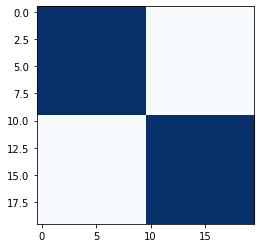

In [12]:
Z_train = torch.zeros(20, 10).float()
Z_train[:10, :5] = 1.
Z_train[10:, 5:] = 1.
Z_train = F.normalize(Z_train)
plt.imshow(Z_train @ Z_train.T, cmap='Blues')

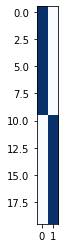

In [13]:
Pi = torch.zeros(20, 2)
Pi[:10, 0] = 1.
Pi[10:, 1] = 1.
plt.imshow(Pi, cmap='Blues')

In [14]:
eps = 0.5
mu = 5.

criterion_mcr2var = MCR2Variational(eps, mu)
true_Us = optimal_Us(Z_train.T, Pi)
Us = nn.Parameter(
#     true_Us,
    torch.randn(2, 10, 10) / 100,
    requires_grad=True
    )
import torch.optim as optim
optimizer_Us = optim.SGD([Us], lr=0.005)

In [15]:
for epoch in range(4000):
    optimizer_Us.zero_grad()
    loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_train, Pi, Us)
    print(epoch, -loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
    loss_obj.backward()
    optimizer_Us.step()

0 -497.51568603515625 2.397895336151123 0.010149279609322548 499.9034423828125
1 -497.3974304199219 2.397895336151123 0.01124522089958191 499.7840881347656
2 -497.1334533691406 2.397895336151123 0.013806093484163284 499.5175476074219
3 -496.5441589355469 2.397895336151123 0.019622156396508217 498.92242431640625
4 -495.2296142578125 2.397895336151123 0.032624904066324234 497.5948791503906
5 -492.3043518066406 2.397895336151123 0.061272092163562775 494.6409606933594
6 -485.8288879394531 2.397895336151123 0.12298503518104553 488.1037902832031
7 -471.664306640625 2.397895336151123 0.2507137358188629 473.8114929199219
8 -441.50384521484375 2.397895336151123 0.4978824257850647 443.40386962890625
9 -381.05657958984375 2.397895336151123 0.930608868598938 382.52386474609375
10 -275.0660400390625 2.397895336151123 1.5907704830169678 275.8731689453125
11 -135.23486328125 2.397895336151123 2.4219605922698975 135.21080017089844
12 -30.670063018798828 2.397895336151123 3.202151298522949 29.865806579

131 -1.0230653285980225 2.397895336151123 3.419246196746826 0.001714452519081533
132 -1.0203777551651 2.397895336151123 3.41656231880188 0.0017107679741457105
133 -1.017693042755127 2.397895336151123 3.413881301879883 0.001707067945972085
134 -1.0150114297866821 2.397895336151123 3.411203384399414 0.001703336602076888
135 -1.0123331546783447 2.397895336151123 3.4085288047790527 0.001699688145890832
136 -1.0096577405929565 2.397895336151123 3.4058570861816406 0.00169601128436625
137 -1.0069856643676758 2.397895336151123 3.403188705444336 0.001692341291345656
138 -1.0043165683746338 2.397895336151123 3.4005231857299805 0.0016886688536033034
139 -1.0016506910324097 2.397895336151123 3.3978610038757324 0.001685027382336557
140 -0.998988151550293 2.397895336151123 3.395202159881592 0.0016813537804409862
141 -0.996328592300415 2.397895336151123 3.3925461769104004 0.001677768537774682
142 -0.9936723113059998 2.397895336151123 3.3898935317993164 0.001674140803515911
143 -0.9910196661949158 2.3

258 -0.7095255851745605 2.397895336151123 3.1061043739318848 0.0013165678828954697
259 -0.7072883248329163 2.397895336151123 3.103869676589966 0.0013139838119968772
260 -0.7050546407699585 2.397895336151123 3.1016385555267334 0.0013114099856466055
261 -0.7028239965438843 2.397895336151123 3.0994105339050293 0.0013088134583085775
262 -0.7005977630615234 2.397895336151123 3.097186803817749 0.001306280493736267
263 -0.6983748078346252 2.397895336151123 3.094966411590576 0.0013037268072366714
264 -0.6961549520492554 2.397895336151123 3.0927491188049316 0.0013011714909225702
265 -0.6939388513565063 2.397895336151123 3.0905356407165527 0.0012985720532014966
266 -0.6917264461517334 2.397895336151123 3.0883257389068604 0.0012960657477378845
267 -0.6895174384117126 2.397895336151123 3.0861191749572754 0.001293581211939454
268 -0.6873113512992859 2.397895336151123 3.0839157104492188 0.0012909832876175642
269 -0.6851091980934143 2.397895336151123 3.0817160606384277 0.001288498635403812
270 -0.682

395 -0.4320361018180847 2.397895336151123 2.8289103507995605 0.001021099160425365
396 -0.4301913380622864 2.397895336151123 2.8270673751831055 0.0010193003108724952
397 -0.42834848165512085 2.397895336151123 2.825226306915283 0.0010175161296501756
398 -0.42650794982910156 2.397895336151123 2.823387622833252 0.0010156689677387476
399 -0.42466944456100464 2.397895336151123 2.8215508460998535 0.0010139286750927567
400 -0.42283278703689575 2.397895336151123 2.819715976715088 0.0010121404193341732
401 -0.4209982454776764 2.397895336151123 2.817883253097534 0.0010103278327733278
402 -0.41916611790657043 2.397895336151123 2.8160529136657715 0.0010085389949381351
403 -0.4173352122306824 2.397895336151123 2.8142237663269043 0.001006772043183446
404 -0.4155066907405853 2.397895336151123 2.812397003173828 0.0010050177806988358
405 -0.4136804938316345 2.397895336151123 2.810572624206543 0.0010032042628154159
406 -0.4118557572364807 2.397895336151123 2.8087496757507324 0.001001432305201888
407 -0.4

522 -0.21080835163593292 2.397895336151123 2.6078877449035645 0.0008159469580277801
523 -0.20914562046527863 2.397895336151123 2.6062264442443848 0.0008145169704221189
524 -0.20748376846313477 2.397895336151123 2.6045660972595215 0.0008130070054903626
525 -0.20582315325737 2.397895336151123 2.6029069423675537 0.0008115416276268661
526 -0.20416304469108582 2.397895336151123 2.601248264312744 0.0008101173443719745
527 -0.20250406861305237 2.397895336151123 2.59959077835083 0.0008086266461759806
528 -0.200845867395401 2.397895336151123 2.5979340076446533 0.0008071976481005549
529 -0.19918860495090485 2.397895336151123 2.596278190612793 0.0008057450759224594
530 -0.1975322663784027 2.397895336151123 2.594623327255249 0.0008042745175771415
531 -0.19587692618370056 2.397895336151123 2.5929694175720215 0.0008028399315662682
532 -0.19422224164009094 2.397895336151123 2.5913162231445312 0.0008013542974367738
533 -0.19256854057312012 2.397895336151123 2.5896639823913574 0.0007998913642950356
534

664 0.017000088468194008 2.397895336151123 2.380272626876831 0.0006226215045899153
665 0.018540088087320328 2.397895336151123 2.3787338733673096 0.0006213748129084706
666 0.020079148933291435 2.397895336151123 2.3771960735321045 0.0006201130454428494
667 0.021617040038108826 2.397895336151123 2.375659465789795 0.0006188300321809947
668 0.023153698071837425 2.397895336151123 2.374124050140381 0.0006175873568281531
669 0.024689437821507454 2.397895336151123 2.372589588165283 0.0006163108046166599
670 0.026223715394735336 2.397895336151123 2.37105655670166 0.0006150649860501289
671 0.02775706723332405 2.397895336151123 2.3695244789123535 0.0006137904128991067
672 0.029289189726114273 2.397895336151123 2.3679935932159424 0.0006125530926510692
673 0.030820094048976898 2.397895336151123 2.3664638996124268 0.0006113421986810863
674 0.03234964609146118 2.397895336151123 2.3649356365203857 0.0006100538303144276
675 0.03387795016169548 2.397895336151123 2.3634085655212402 0.0006088193040341139
6

808 0.2211560308933258 2.397895336151123 2.1762819290161133 0.000457369169453159
809 0.22240041196346283 2.397895336151123 2.1750385761260986 0.000456349371233955
810 0.22364144027233124 2.397895336151123 2.1737985610961914 0.0004553398466669023
811 0.22487978637218475 2.397895336151123 2.1725611686706543 0.0004543824470601976
812 0.22611437737941742 2.397895336151123 2.171327590942383 0.00045336311450228095
813 0.22734655439853668 2.397895336151123 2.1700963973999023 0.0004523777752183378
814 0.2285749316215515 2.397895336151123 2.1688690185546875 0.00045138716814108193
815 0.22980041801929474 2.397895336151123 2.167644500732422 0.0004504151875153184
816 0.23102281987667084 2.397895336151123 2.1664230823516846 0.00044943613465875387
817 0.2322418987751007 2.397895336151123 2.1652050018310547 0.00044843927025794983
818 0.23345761001110077 2.397895336151123 2.1639902591705322 0.0004474683664739132
819 0.2346702665090561 2.397895336151123 2.162778615951538 0.0004464609082788229
820 0.235

946 0.3594680726528168 2.397895336151123 2.038081169128418 0.0003460813604760915
947 0.3602111339569092 2.397895336151123 2.0373387336730957 0.00034547975519672036
948 0.3609505593776703 2.397895336151123 2.03659987449646 0.00034490498364903033
949 0.36168617010116577 2.397895336151123 2.03586483001709 0.00034434610279276967
950 0.3624182641506195 2.397895336151123 2.0351333618164062 0.00034372357185930014
951 0.36314648389816284 2.397895336151123 2.0344057083129883 0.00034314158256165683
952 0.36387139558792114 2.397895336151123 2.0336813926696777 0.00034254748607054353
953 0.36459222435951233 2.397895336151123 2.032961130142212 0.0003419936983846128
954 0.3653097152709961 2.397895336151123 2.0322442054748535 0.00034141444484703243
955 0.3660236597061157 2.397895336151123 2.0315308570861816 0.0003408301272429526
956 0.36673352122306824 2.397895336151123 2.0308215618133545 0.00034025023342110217
957 0.36744028329849243 2.397895336151123 2.0301153659820557 0.0003396824758965522
958 0.36

1089 0.43312573432922363 2.397895336151123 1.9644818305969238 0.00028778164414688945
1090 0.43345093727111816 2.397895336151123 1.9641568660736084 0.00028752911021001637
1091 0.4337739944458008 2.397895336151123 1.9638340473175049 0.00028728143661282957
1092 0.43409550189971924 2.397895336151123 1.9635127782821655 0.00028705125441774726
1093 0.43441489338874817 2.397895336151123 1.963193655014038 0.0002867859147954732
1094 0.43473199009895325 2.397895336151123 1.962876796722412 0.00028655497590079904
1095 0.4350473880767822 2.397895336151123 1.9625616073608398 0.00028633049805648625
1096 0.4353606700897217 2.397895336151123 1.9622485637664795 0.00028609667788259685
1097 0.4356723129749298 2.397895336151123 1.9619371891021729 0.0002858279040083289
1098 0.43598198890686035 2.397895336151123 1.961627721786499 0.0002856214123312384
1099 0.43628934025764465 2.397895336151123 1.9613206386566162 0.00028536940226331353
1100 0.43659520149230957 2.397895336151123 1.961014986038208 0.000285146525

1230 0.4643724858760834 2.397895336151123 1.9332568645477295 0.0002659785677678883
1231 0.4645213782787323 2.397895336151123 1.9331080913543701 0.0002658749872352928
1232 0.46466973423957825 2.397895336151123 1.932959794998169 0.0002657997829373926
1233 0.46481752395629883 2.397895336151123 1.9328120946884155 0.00026571887428872287
1234 0.4649645686149597 2.397895336151123 1.9326651096343994 0.0002656443393789232
1235 0.46511104702949524 2.397895336151123 1.932518720626831 0.0002655557473190129
1236 0.46525704860687256 2.397895336151123 1.932372808456421 0.0002654813870321959
1237 0.4654023349285126 2.397895336151123 1.932227611541748 0.0002653799019753933
1238 0.4655469059944153 2.397895336151123 1.9320831298828125 0.0002653001865837723
1239 0.46569088101387024 2.397895336151123 1.9319392442703247 0.0002651999529916793
1240 0.465834379196167 2.397895336151123 1.9317958354949951 0.00026511569740250707
1241 0.4659772515296936 2.397895336151123 1.9316530227661133 0.0002650572860147804
12

1376 0.4818914532661438 2.397895336151123 1.9157462120056152 0.00025768103660084307
1377 0.4819958806037903 2.397895336151123 1.9156417846679688 0.00025767466286197305
1378 0.48210036754608154 2.397895336151123 1.9155373573303223 0.00025761465076357126
1379 0.4822045564651489 2.397895336151123 1.9154331684112549 0.00025760725839063525
1380 0.4823088049888611 2.397895336151123 1.9153289794921875 0.0002575585385784507
1381 0.48241305351257324 2.397895336151123 1.9152247905731201 0.00025750609347596765
1382 0.4825170040130615 2.397895336151123 1.9151208400726318 0.00025749558699317276
1383 0.48262137174606323 2.397895336151123 1.915016531944275 0.00025744695449247956
1384 0.48272523283958435 2.397895336151123 1.9149127006530762 0.0002574101381469518
1385 0.482829213142395 2.397895336151123 1.914808750152588 0.00025738502154126763
1386 0.4829331934452057 2.397895336151123 1.9147047996520996 0.00025735393865033984
1387 0.4830370545387268 2.397895336151123 1.9146009683609009 0.00025729986373

1516 0.4966554641723633 2.397895336151123 1.9009864330291748 0.00025345076574012637
1517 0.496766597032547 2.397895336151123 1.9008753299713135 0.00025341464788652956
1518 0.4968777298927307 2.397895336151123 1.9007642269134521 0.000253391161095351
1519 0.49698910117149353 2.397895336151123 1.9006528854370117 0.0002533484366722405
1520 0.49710068106651306 2.397895336151123 1.9005413055419922 0.000253353820880875
1521 0.4972124397754669 2.397895336151123 1.900429606437683 0.00025330341304652393
1522 0.49732425808906555 2.397895336151123 1.9003177881240845 0.0002532958460506052
1523 0.497435986995697 2.397895336151123 1.9002060890197754 0.00025326735340058804
1524 0.49754807353019714 2.397895336151123 1.9000940322875977 0.000253229693043977
1525 0.4976603090763092 2.397895336151123 1.8999818563461304 0.00025318528059870005
1526 0.4977726936340332 2.397895336151123 1.899869441986084 0.0002531995123717934
1527 0.4978852868080139 2.397895336151123 1.899756908416748 0.0002531260543037206
152

1656 0.5138959288597107 2.397895336151123 1.8837499618530273 0.0002494395594112575
1657 0.5140337347984314 2.397895336151123 1.8836121559143066 0.0002494175569154322
1658 0.514171838760376 2.397895336151123 1.8834741115570068 0.0002493727079126984
1659 0.5143104195594788 2.397895336151123 1.8833355903625488 0.00024933519307523966
1660 0.5144489407539368 2.397895336151123 1.8831970691680908 0.0002493135689292103
1661 0.5145877003669739 2.397895336151123 1.8830583095550537 0.0002493016654625535
1662 0.5147267580032349 2.397895336151123 1.8829193115234375 0.0002492436906322837
1663 0.514866054058075 2.397895336151123 1.8827800750732422 0.0002492225612513721
1664 0.5150057673454285 2.397895336151123 1.8826403617858887 0.00024918411509133875
1665 0.5151456594467163 2.397895336151123 1.8825005292892456 0.0002491522172931582
1666 0.5152857303619385 2.397895336151123 1.8823604583740234 0.00024914852110669017
1667 0.5154262185096741 2.397895336151123 1.8822200298309326 0.0002490915940143168
166

1800 0.5365921258926392 2.397895336151123 1.8610589504241943 0.00024423407739959657
1801 0.5367721915245056 2.397895336151123 1.8608789443969727 0.00024418439716100693
1802 0.5369526147842407 2.397895336151123 1.8606985807418823 0.0002441357501083985
1803 0.537133514881134 2.397895336151123 1.8605177402496338 0.00024410257174167782
1804 0.5373147130012512 2.397895336151123 1.8603365421295166 0.00024406815646216273
1805 0.5374962091445923 2.397895336151123 1.8601551055908203 0.00024403270799666643
1806 0.537678062915802 2.397895336151123 1.8599733114242554 0.0002439631789457053
1807 0.5378602147102356 2.397895336151123 1.8597911596298218 0.0002439339878037572
1808 0.5380427837371826 2.397895336151123 1.8596086502075195 0.00024387426674365997
1809 0.5382257103919983 2.397895336151123 1.8594257831573486 0.00024383682466577739
1810 0.5384091138839722 2.397895336151123 1.8592424392700195 0.00024380069226026535
1811 0.5385927557945251 2.397895336151123 1.8590588569641113 0.000243753078393638

1939 0.5653191804885864 2.397895336151123 1.8323390483856201 0.00023712775146123022
1940 0.5655554533004761 2.397895336151123 1.8321027755737305 0.00023708448861725628
1941 0.5657925605773926 2.397895336151123 1.8318657875061035 0.0002370155561948195
1942 0.5660296082496643 2.397895336151123 1.8316287994384766 0.00023695529671385884
1943 0.5662673711776733 2.397895336151123 1.8313910961151123 0.0002368688292335719
1944 0.5665057897567749 2.397895336151123 1.8311526775360107 0.00023685184714850038
1945 0.5667445659637451 2.397895336151123 1.83091402053833 0.00023677550780121237
1946 0.5669837594032288 2.397895336151123 1.8306748867034912 0.0002367177658015862
1947 0.5672234296798706 2.397895336151123 1.8304352760314941 0.00023663169122301042
1948 0.5674638152122498 2.397895336151123 1.8301949501037598 0.00023658816644456238
1949 0.567704439163208 2.397895336151123 1.8299543857574463 0.00023651731316931546
1950 0.5679455399513245 2.397895336151123 1.8297133445739746 0.0002364647662034258

2083 0.6046546697616577 2.397895336151123 1.7930142879486084 0.00022634929337073117
2084 0.6049685478210449 2.397895336151123 1.7927005290985107 0.0002262559428345412
2085 0.6052831411361694 2.397895336151123 1.7923860549926758 0.00022616753994952887
2086 0.6055981516838074 2.397895336151123 1.7920711040496826 0.00022606542916037142
2087 0.6059139370918274 2.397895336151123 1.7917554378509521 0.00022597514907829463
2088 0.6062301993370056 2.397895336151123 1.7914392948150635 0.00022586142586078495
2089 0.6065471172332764 2.397895336151123 1.7911224365234375 0.0002257907181046903
2090 0.6068646311759949 2.397895336151123 1.7908049821853638 0.0002256974985357374
2091 0.6071828007698059 2.397895336151123 1.7904869318008423 0.0002256024454254657
2092 0.6075015664100647 2.397895336151123 1.790168285369873 0.00022551161237061024
2093 0.6078207492828369 2.397895336151123 1.7898491621017456 0.0002254188002552837
2094 0.6081408262252808 2.397895336151123 1.7895292043685913 0.0002253162092529237

2214 0.6512219905853271 2.397895336151123 1.7464616298675537 0.0002117269905284047
2215 0.6516212224960327 2.397895336151123 1.7460625171661377 0.00021158988238312304
2216 0.6520211696624756 2.397895336151123 1.7456626892089844 0.0002114519156748429
2217 0.6524217128753662 2.397895336151123 1.7452622652053833 0.000211331935133785
2218 0.6528230309486389 2.397895336151123 1.744861125946045 0.00021117253345437348
2219 0.6532248854637146 2.397895336151123 1.7444593906402588 0.0002110489149345085
2220 0.6536274552345276 2.397895336151123 1.7440569400787354 0.00021091499365866184
2221 0.6540307998657227 2.397895336151123 1.7436537742614746 0.0002107764157699421
2222 0.6544346809387207 2.397895336151123 1.7432500123977661 0.00021065383043605834
2223 0.654839277267456 2.397895336151123 1.7428455352783203 0.0002105004241457209
2224 0.6552445292472839 2.397895336151123 1.7424404621124268 0.00021036859834566712
2225 0.6556505560874939 2.397895336151123 1.7420345544815063 0.0002102358703268692
22

2350 0.7112714052200317 2.397895336151123 1.6864341497421265 0.00018978914886247367
2351 0.7117497324943542 2.397895336151123 1.6859560012817383 0.00018958744476549327
2352 0.7122284173965454 2.397895336151123 1.6854774951934814 0.00018941798771265894
2353 0.71270751953125 2.397895336151123 1.684998631477356 0.00018920966249424964
2354 0.713187038898468 2.397895336151123 1.6845192909240723 0.00018901877047028393
2355 0.7136666774749756 2.397895336151123 1.684039831161499 0.00018882291624322534
2356 0.7141469120979309 2.397895336151123 1.683559775352478 0.0001886444224510342
2357 0.7146275043487549 2.397895336151123 1.6830793619155884 0.0001884487719507888
2358 0.7151084542274475 2.397895336151123 1.68259859085083 0.00018826802261173725
2359 0.715589702129364 2.397895336151123 1.6821175813674927 0.0001880752679426223
2360 0.716071367263794 2.397895336151123 1.681636095046997 0.0001878722250694409
2361 0.716553270816803 2.397895336151123 1.6811543703079224 0.0001876875467132777
2362 0.71

2495 0.7815437316894531 2.397895336151123 1.6161919832229614 0.0001596147776581347
2496 0.782007098197937 2.397895336151123 1.6157288551330566 0.00015940223238430917
2497 0.7824695706367493 2.397895336151123 1.6152665615081787 0.0001591945911059156
2498 0.782931387424469 2.397895336151123 1.614804983139038 0.00015896500553935766
2499 0.7833924889564514 2.397895336151123 1.6143441200256348 0.00015875091776251793
2500 0.7838528156280518 2.397895336151123 1.6138839721679688 0.00015854841331019998
2501 0.7843124270439148 2.397895336151123 1.61342453956604 0.0001583453849889338
2502 0.7847711443901062 2.397895336151123 1.6129660606384277 0.00015813193749636412
2503 0.7852291464805603 2.397895336151123 1.6125082969665527 0.00015790053294040263
2504 0.785686194896698 2.397895336151123 1.6120514869689941 0.00015768302546348423
2505 0.7861427068710327 2.397895336151123 1.6115951538085938 0.00015749296289868653
2506 0.7865980267524719 2.397895336151123 1.6111400127410889 0.00015727811842225492
2

2636 0.8359206318855286 2.397895336151123 1.5618412494659424 0.00013346917694434524
2637 0.8362084031105042 2.397895336151123 1.5615535974502563 0.00013332725211512297
2638 0.8364946842193604 2.397895336151123 1.5612674951553345 0.0001331834791926667
2639 0.8367793560028076 2.397895336151123 1.5609829425811768 0.0001330418308498338
2640 0.8370627164840698 2.397895336151123 1.560699701309204 0.0001328983053099364
2641 0.8373443484306335 2.397895336151123 1.5604182481765747 0.00013275757373776287
2642 0.8376246094703674 2.397895336151123 1.5601381063461304 0.0001326261553913355
2643 0.8379033207893372 2.397895336151123 1.5598595142364502 0.0001324764743912965
2644 0.8381805419921875 2.397895336151123 1.5595824718475342 0.00013234990183264017
2645 0.8384562730789185 2.397895336151123 1.5593068599700928 0.00013220901018939912
2646 0.8387304544448853 2.397895336151123 1.5590327978134155 0.0001320629962719977
2647 0.8390032649040222 2.397895336151123 1.558760166168213 0.00013192699407227337


2782 0.863563597202301 2.397895336151123 1.5342121124267578 0.00011962774442508817
2783 0.8636701107025146 2.397895336151123 1.534105658531189 0.00011956499656662345
2784 0.8637757897377014 2.397895336151123 1.534000039100647 0.0001195165968965739
2785 0.8638806343078613 2.397895336151123 1.5338952541351318 0.00011947180610150099
2786 0.8639846444129944 2.397895336151123 1.5337913036346436 0.00011940495460294187
2787 0.8640876412391663 2.397895336151123 1.5336883068084717 0.00011936019291169941
2788 0.8641899824142456 2.397895336151123 1.533586025238037 0.00011931009794352576
2789 0.8642913699150085 2.397895336151123 1.533484697341919 0.00011925882427021861
2790 0.8643920421600342 2.397895336151123 1.533384084701538 0.00011919563985429704
2791 0.8644919991493225 2.397895336151123 1.5332841873168945 0.00011914619972230867
2792 0.8645910024642944 2.397895336151123 1.5331852436065674 0.00011910866305697709
2793 0.864689290523529 2.397895336151123 1.5330870151519775 0.00011905509745702147


2918 0.8722115755081177 2.397895336151123 1.5255684852600098 0.00011526512389536947
2919 0.8722443580627441 2.397895336151123 1.5255357027053833 0.00011525300214998424
2920 0.8722769618034363 2.397895336151123 1.525503158569336 0.00011522647400852293
2921 0.8723090291023254 2.397895336151123 1.5254710912704468 0.00011520802945597097
2922 0.872340977191925 2.397895336151123 1.5254391431808472 0.00011520572297740728
2923 0.872372567653656 2.397895336151123 1.5254075527191162 0.00011518901737872511
2924 0.8724038600921631 2.397895336151123 1.525376319885254 0.00011516711674630642
2925 0.8724349737167358 2.397895336151123 1.5253452062606812 0.00011514636571519077
2926 0.8724657297134399 2.397895336151123 1.525314450263977 0.00011513599019963294
2927 0.8724961876869202 2.397895336151123 1.5252840518951416 0.00011511583579704165
2928 0.8725264668464661 2.397895336151123 1.5252537727355957 0.00011511525372043252
2929 0.8725565075874329 2.397895336151123 1.525223731994629 0.0001151025935541838

3056 0.8747835159301758 2.397895336151123 1.5229978561401367 0.00011396946501918137
3057 0.8747925758361816 2.397895336151123 1.5229887962341309 0.00011396489571779966
3058 0.8748016357421875 2.397895336151123 1.522979736328125 0.0001139700470957905
3059 0.8748104572296143 2.397895336151123 1.5229709148406982 0.00011395236651878804
3060 0.8748193979263306 2.397895336151123 1.522961974143982 0.00011395635374356061
3061 0.8748281002044678 2.397895336151123 1.5229532718658447 0.00011395235196687281
3062 0.8748366832733154 2.397895336151123 1.522944688796997 0.00011394837201805785
3063 0.8748453855514526 2.397895336151123 1.5229359865188599 0.00011393866589060053
3064 0.8748539090156555 2.397895336151123 1.5229275226593018 0.00011393411114113405
3065 0.8748624920845032 2.397895336151123 1.522918939590454 0.0001139318264904432
3066 0.8748707175254822 2.397895336151123 1.522910714149475 0.0001139261294156313
3067 0.8748789429664612 2.397895336151123 1.522902488708496 0.00011392385204089805
3

3197 0.875495433807373 2.397895336151123 1.522286295890808 0.0001136226492235437
3198 0.8754978179931641 2.397895336151123 1.522283911705017 0.0001136220816988498
3199 0.8755002021789551 2.397895336151123 1.522281527519226 0.00011362151417415589
3200 0.8755024671554565 2.397895336151123 1.5222792625427246 0.00011361924407538027
3201 0.8755048513412476 2.397895336151123 1.5222768783569336 0.00011361468932591379
3202 0.8755072355270386 2.397895336151123 1.5222744941711426 0.0001136089995270595
3203 0.8755093812942505 2.397895336151123 1.5222723484039307 0.00011360162170603871
3204 0.8755117654800415 2.397895336151123 1.5222699642181396 0.00011359479685779661
3205 0.8755139112472534 2.397895336151123 1.5222678184509277 0.00011360105418134481
3206 0.8755160570144653 2.397895336151123 1.5222656726837158 0.00011359422205714509
3207 0.8755182027816772 2.397895336151123 1.522263526916504 0.00011359878408256918
3208 0.8755205869674683 2.397895336151123 1.522261142730713 0.00011359650670783594
3

3330 0.8756766319274902 2.397895336151123 1.5221052169799805 0.00011351410648785532
3331 0.8756773471832275 2.397895336151123 1.5221045017242432 0.0001135135316872038
3332 0.8756780028343201 2.397895336151123 1.5221037864685059 0.00011351751163601875
3333 0.8756786584854126 2.397895336151123 1.522103190422058 0.00011350728163961321
3334 0.8756791949272156 2.397895336151123 1.5221025943756104 0.00011352716683177277
3335 0.8756799101829529 2.397895336151123 1.522101879119873 0.00011352318688295782
3336 0.875680685043335 2.397895336151123 1.5221011638641357 0.00011351410648785532
3337 0.8756811618804932 2.397895336151123 1.5221006870269775 0.00011350160639267415
3338 0.8756818175315857 2.397895336151123 1.5220999717712402 0.00011353171430528164
3339 0.8756824135780334 2.397895336151123 1.5220993757247925 0.00011353057925589383
3340 0.8756830096244812 2.397895336151123 1.5220987796783447 0.00011352205183357
3341 0.8756836652755737 2.397895336151123 1.522098183631897 0.00011351070133969188


3460 0.8757270574569702 2.397895336151123 1.5220547914505005 0.0001134970661951229
3461 0.8757271766662598 2.397895336151123 1.522054672241211 0.00011351070133969188
3462 0.8757274150848389 2.397895336151123 1.5220544338226318 0.00011348399857524782
3463 0.875727653503418 2.397895336151123 1.5220541954040527 0.00011349366104695946
3464 0.8757278919219971 2.397895336151123 1.5220539569854736 0.00011350728163961321
3465 0.8757280111312866 2.397895336151123 1.522053837776184 0.00011350160639267415
3466 0.8757281303405762 2.397895336151123 1.5220537185668945 0.00011351126158842817
3467 0.8757283687591553 2.397895336151123 1.5220534801483154 0.00011350217391736805
3468 0.8757286071777344 2.397895336151123 1.5220532417297363 0.00011350728163961321
3469 0.8757288455963135 2.397895336151123 1.5220530033111572 0.00011351126158842817
3470 0.875728964805603 2.397895336151123 1.5220528841018677 0.00011348797852406278
3471 0.8757290840148926 2.397895336151123 1.5220527648925781 0.000113493661046959

3604 0.8757424354553223 2.397895336151123 1.5220394134521484 0.00011347945837769657
3605 0.8757424354553223 2.397895336151123 1.5220394134521484 0.00011348001862643287
3606 0.8757424354553223 2.397895336151123 1.5220394134521484 0.00011348001862643287
3607 0.8757424354553223 2.397895336151123 1.5220394134521484 0.00011348001862643287
3608 0.8757425546646118 2.397895336151123 1.5220392942428589 0.00011348001862643287
3609 0.8757426738739014 2.397895336151123 1.5220391750335693 0.00011348910629749298
3610 0.8757426738739014 2.397895336151123 1.5220391750335693 0.00011349366104695946
3611 0.8757426738739014 2.397895336151123 1.5220391750335693 0.00011349422857165337
3612 0.8757427930831909 2.397895336151123 1.5220390558242798 0.00011348797852406278
3613 0.8757427930831909 2.397895336151123 1.5220390558242798 0.00011348797852406278
3614 0.8757429122924805 2.397895336151123 1.5220389366149902 0.00011348797852406278
3615 0.8757429122924805 2.397895336151123 1.5220389366149902 0.0001134970661

3738 0.8757461309432983 2.397895336151123 1.5220357179641724 0.00011348797852406278
3739 0.8757461309432983 2.397895336151123 1.5220357179641724 0.00011348797852406278
3740 0.8757461309432983 2.397895336151123 1.5220357179641724 0.00011348797852406278
3741 0.8757462501525879 2.397895336151123 1.5220355987548828 0.00011348797852406278
3742 0.8757462501525879 2.397895336151123 1.5220355987548828 0.00011348797852406278
3743 0.8757462501525879 2.397895336151123 1.5220355987548828 0.00011348797852406278
3744 0.8757462501525879 2.397895336151123 1.5220355987548828 0.00011348797852406278
3745 0.8757462501525879 2.397895336151123 1.5220355987548828 0.00011348797852406278
3746 0.8757462501525879 2.397895336151123 1.5220355987548828 0.00011348797852406278
3747 0.8757462501525879 2.397895336151123 1.5220355987548828 0.00011348797852406278
3748 0.8757462501525879 2.397895336151123 1.5220355987548828 0.00011348797852406278
3749 0.8757462501525879 2.397895336151123 1.5220355987548828 0.0001134879785

3882 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3883 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3884 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3885 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3886 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3887 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3888 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3889 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3890 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3891 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3892 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348001862643287
3893 0.8757472038269043 2.397895336151123 1.5220346450805664 0.0001134800186

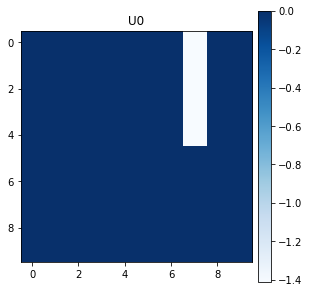

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(Us[0].detach(), cmap='Blues')
ax.set_title('U0')
fig.colorbar(im, pad=0.02, drawedges=0)

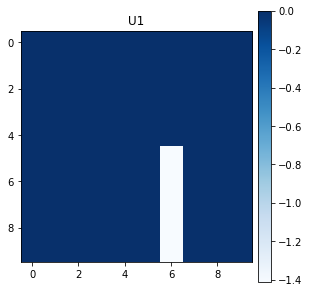

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(Us[1].detach(), cmap='Blues')
ax.set_title('U1')
fig.colorbar(im, pad=0.02, drawedges=0)

Text(0.5, 1.0, 'U1 @ U1.T')

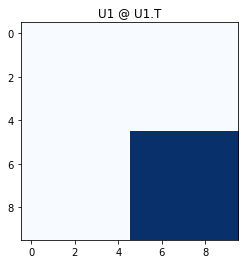

In [20]:
plt.imshow(Us[1].detach() @ Us[1].detach().T, cmap='Blues')
plt.title('U1 @ U1.T')

## Verification 2

In [106]:
Z = torch.randn(20, 10)
U, S, Vh = torch.linalg.svd(Z.T @ Pi[:, 0].diag() @ Z)
# torch.linalg.norm(U @ (S**0.5).diag() @ (S**0.5).diag() @ Vh - Z.T @ Pi[:, 0].diag() @ Z, ord='fro')
torch.linalg.norm((U @ (S**0.5).diag()) @ (U @ (S**0.5).diag()).T - Z.T @ Pi[:, 0].diag() @ Z, ord='fro')
# torch.linalg.norm((U) @ (U).T - Z.T @ Pi[:, 0].diag() @ Z, ord='fro')

tensor(1.3875e-05)

In [107]:
Z = torch.randn(20, 10)
S, V = torch.linalg.eigh(Z.T @ Pi[:, 0].diag() @ Z)
torch.linalg.norm(V @ (S**0.5).diag() @ (S**0.5).diag() @ V.T - Z.T @ Pi[:, 0].diag() @ Z, ord='fro')

tensor(1.8549e-05)

In [114]:
init_Us = []
for j in range(2):
    U, S, Vh = torch.linalg.svd(Z.T @ Pi[:, j].diag() @ Z)
    U = U @ (S**0.5).diag()
    print(torch.linalg.norm(U @ U.T - Z.T @ Pi[:, j].diag() @ Z, ord='fro'))
    init_Us.append(U @ (S**0.5).diag())

tensor(2.2491e-05)
tensor(2.0224e-05)


In [115]:
torch.linalg.norm(U @ (U).T - Z.T @ Pi[:, 0].diag() @ Z, ord='fro')

tensor(41.3466)

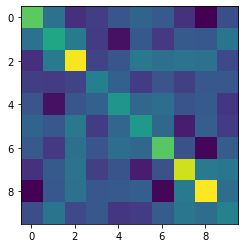

In [116]:
plt.imshow(U @ U.T)

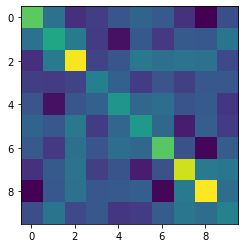

In [117]:
plt.imshow(Z.T @ Pi[:, j].diag() @ Z)